## EDA_mk

---

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = InlineBackend.figure_formats{'png', 'retina'}
from ipyleaflet import *
import time
from scipy.stats import describe
sns.set()

NameError: name 'sns' is not defined

In [2]:
taxi = pd.read_csv('train.csv')

FileNotFoundError: File b'train.csv' does not exist

#### 좌표 묶기, 나누기

In [3]:
taxi['pickup'] = list(zip(taxi['pickup_latitude'], taxi['pickup_longitude']))
taxi['dropoff'] = list(zip(taxi['dropoff_latitude'], taxi['pickup_longitude']))
taxi[['pickup_date', 'pickup_time']] = taxi.pickup_datetime.str.split(expand=True)
taxi[['dropoff_date', 'dropoff_time']] = taxi.dropoff_datetime.str.split(expand=True)

#### change datetype to calculate

In [4]:
taxi['pickup_datetime'] = taxi['pickup_datetime'].astype('datetime64[ns]')
taxi['dropoff_datetime'] = taxi['dropoff_datetime'].astype('datetime64[ns]')
taxi["year"] = taxi['pickup_datetime'].dt.year
taxi["month"] = taxi['pickup_datetime'].dt.month
taxi["day"] = taxi['pickup_datetime'].dt.day
taxi["hour"] = taxi['pickup_datetime'].dt.hour

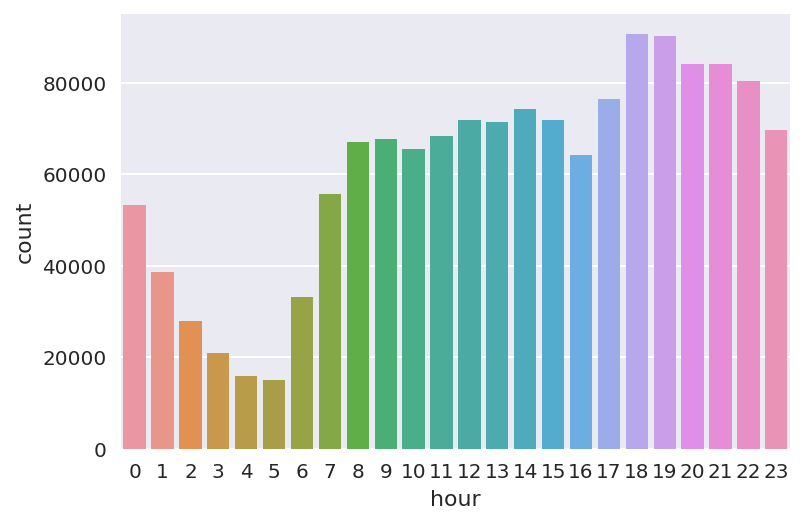

In [5]:
sns.countplot(x = 'hour', data = taxi)
plt.show()

#### dist: direct distance

In [6]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [7]:
taxi['dist'] = \
    haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'],
                 taxi['dropoff_longitude'], taxi['dropoff_latitude'])

### velocity

In [8]:
taxi['velo'] = taxi['dist']/taxi['trip_duration']*3600 #km/h

In [9]:
taxi = taxi[taxi['velo']<80] # 80이상 삭제

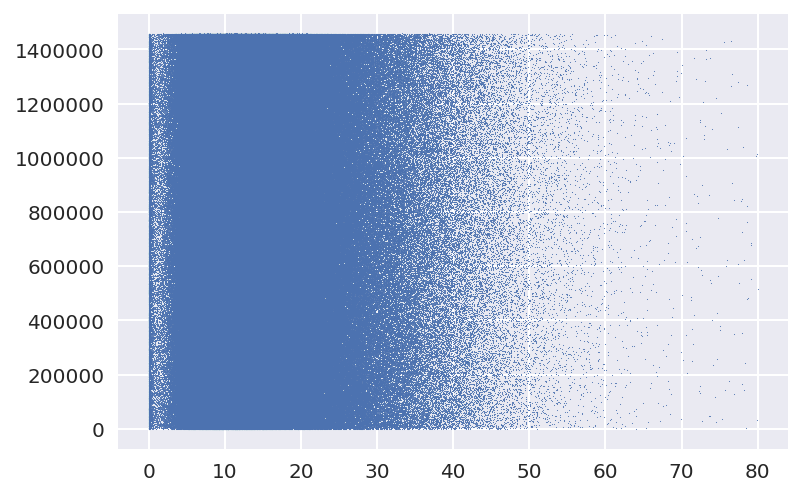

In [10]:
plt.scatter(taxi['velo'], taxi.index, s=0.05)

---

# check outlier

### trip_duration

In [11]:
len(taxi['trip_duration'][taxi['trip_duration'] < 60]) #1분 이하

8432

In [12]:
len(taxi['trip_duration'][taxi['trip_duration'] < 30]) # 30초 이하 탑승

4635

가설1: 1분 이하 탑승객은 오작동(기계 조작 실수 등)이 아닐까?
- 어느정도의 기간이 적당?
- 1-2: 잘못누른거면 거리의 이동이 없을 수도?

In [13]:
taxi = taxi[taxi['trip_duration']>30].reset_index(drop=True) # 30초 이하 탑승 제거

In [14]:
taxi = taxi[taxi['trip_duration']<86400].reset_index(drop=True) # 24시간 이상 탑승 제거

### dist

In [15]:
taxi = taxi[taxi['dist']<180].reset_index(drop=True) #180km 이상 이동 제거

In [16]:
taxi = taxi[taxi['dist']>0.0001].reset_index(drop=True) #10cm 이하 이동 제거

In [17]:
len(taxi)

1449116

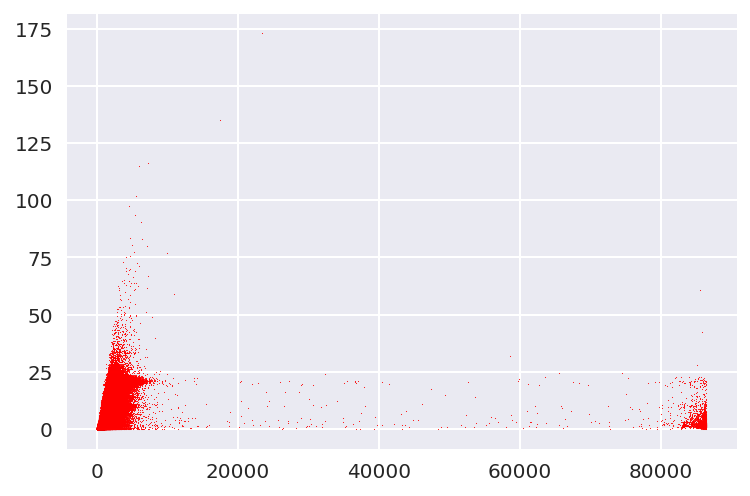

In [18]:
plt.scatter(taxi['trip_duration'], taxi['dist'], s=0.05, c='red')
plt.show()

more strick

In [19]:
len(taxi[taxi['trip_duration']<7500])

1446904

In [20]:
taxi = taxi[taxi['trip_duration']<7500].reset_index(drop=True) # 2시간이상 탑승 제거

In [21]:
len(taxi['dist'][taxi['dist'] < 0.001])  #1m 이하 이동

195

In [22]:
taxi = taxi[taxi['dist'] > 0.001].reset_index(drop=True)  #1m 이하 이동 제거

In [23]:
len(taxi)

1446709

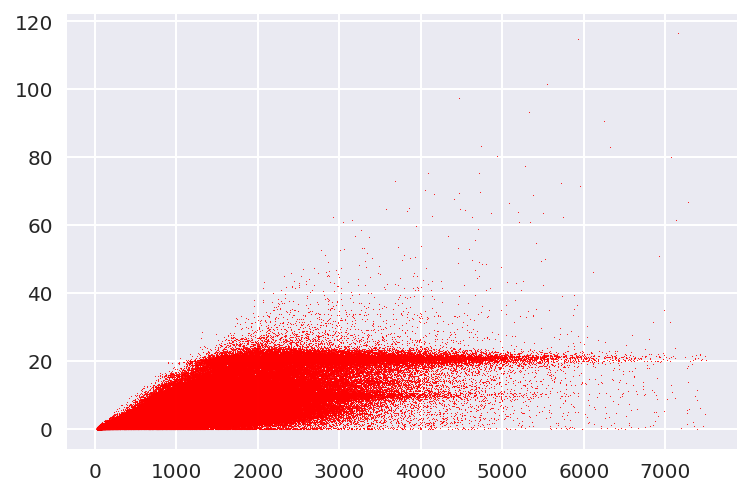

In [24]:
plt.scatter(taxi['trip_duration'], taxi['dist'], s=0.05, c='red')
plt.show() # 양쪽에 쌓인 애들도 정리 필요

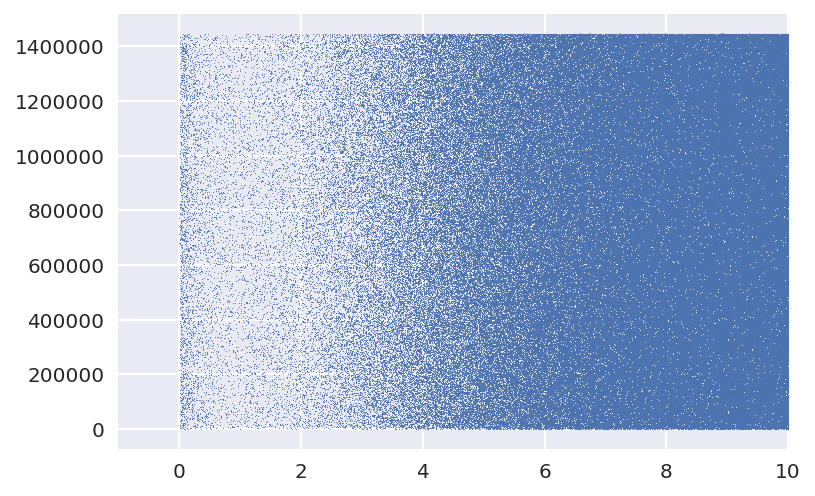

In [25]:
plt.xlim(-1, 10)
plt.scatter(taxi['velo'], taxi.index, s=0.05)

In [26]:
taxi = taxi[taxi['velo']>1] # 1 이하 삭제

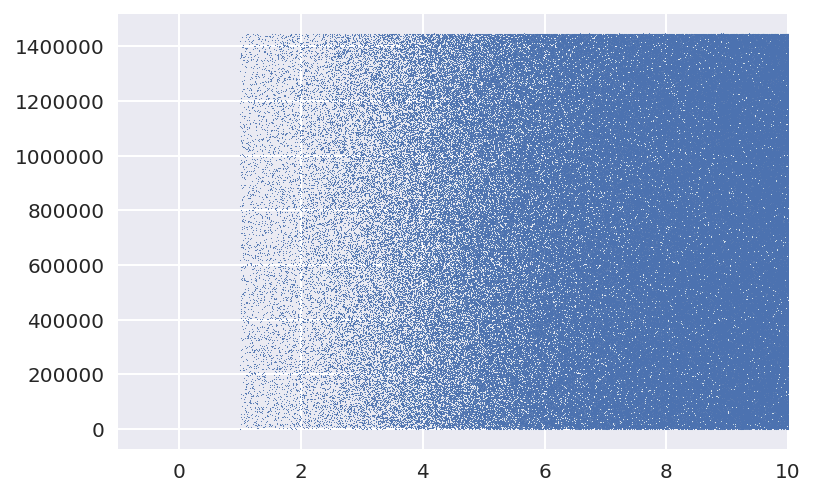

In [27]:
plt.xlim(-1, 10)
plt.scatter(taxi['velo'], taxi.index, s=0.05)

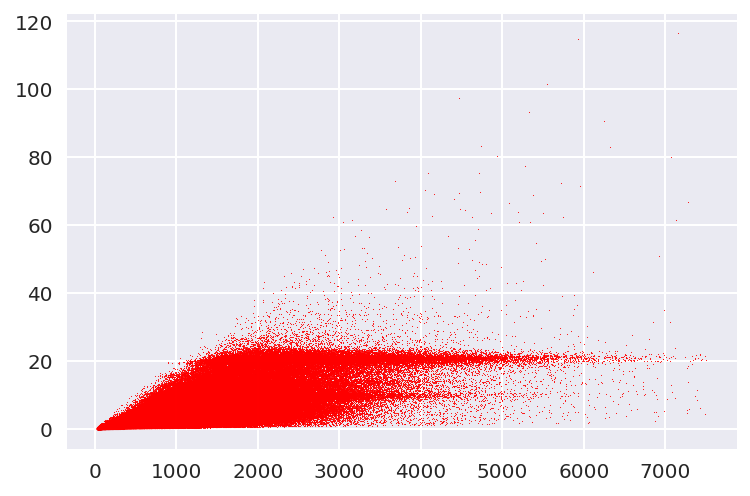

In [28]:
plt.scatter(taxi['trip_duration'], taxi['dist'], s=0.05, c='red')
plt.show() 

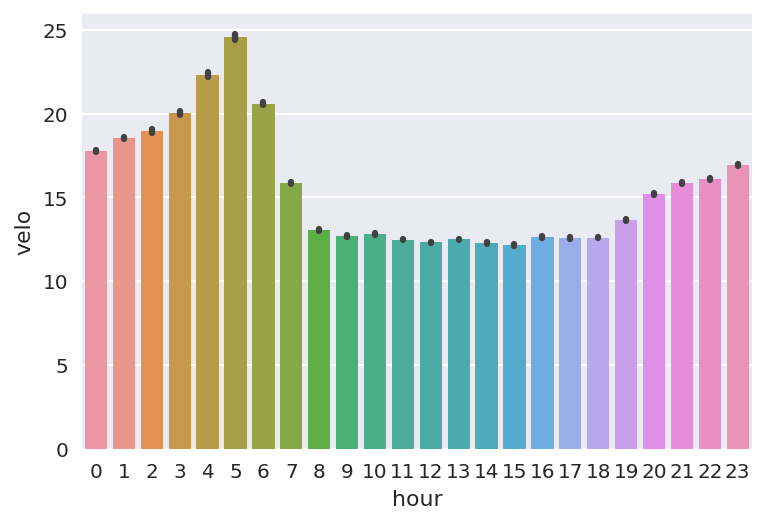

In [29]:
sns.barplot(x='hour', y='velo', data=taxi)
plt.show() 

---

In [30]:
describe(taxi['trip_duration'])

DescribeResult(nobs=1442613, minmax=(31, 7498), mean=839.10934533377974, variance=426203.18354383513, skewness=2.213204707286229, kurtosis=7.872155418142478)

In [31]:
describe(taxi['velo'])

DescribeResult(nobs=1442613, minmax=(1.0003767554001011, 79.895030813855641), mean=14.487986775370951, variance=58.367939536902547, skewness=1.4558218606647064, kurtosis=3.222571573901865)

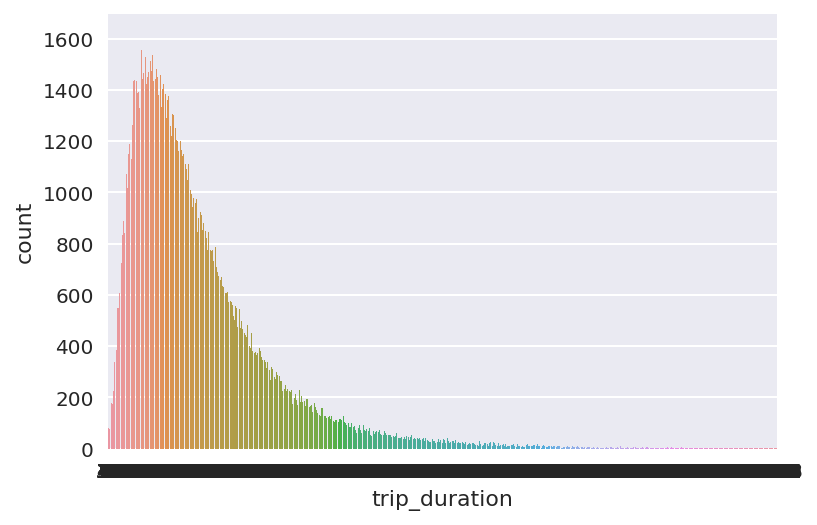

In [32]:
sns.countplot(x = 'trip_duration', data = taxi)
plt.show()

## distance

---

In [34]:
tx = taxi

In [35]:
del tx['pickup_longitude']
del tx['pickup_latitude']
del tx['dropoff_longitude']
del tx['dropoff_latitude']

In [36]:
tx.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'store_and_fwd_flag', 'trip_duration', 'pickup',
       'dropoff', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time',
       'year', 'month', 'day', 'hour', 'dist', 'velo'],
      dtype='object')

In [37]:
tx.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,pickup,dropoff,pickup_date,pickup_time,dropoff_date,dropoff_time,year,month,day,hour,dist,velo
1446704,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,N,778,"(40.7455215454, -73.9822006226)","(40.7401695251, -73.9822006226)",2016-04-08,13:31:04,2016-04-08,13:44:02,2016,4,8,13,1.224311,5.665192
1446705,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,N,655,"(40.747379303, -74.0009460449)","(40.796546936, -74.0009460449)",2016-01-10,07:35:15,2016-01-10,07:46:10,2016,1,10,7,6.046037,33.230128
1446706,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,N,764,"(40.7687988281, -73.9591293335)","(40.7073707581, -73.9591293335)",2016-04-22,06:57:41,2016-04-22,07:10:25,2016,4,22,6,7.819693,36.846722
1446707,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,N,373,"(40.7490615845, -73.9820785522)","(40.757106781, -73.9820785522)",2016-01-05,15:56:26,2016-01-05,16:02:39,2016,1,5,15,1.091878,10.538232
1446708,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,N,198,"(40.7817497253, -73.9795379639)","(40.7905845642, -73.9795379639)",2016-04-05,14:44:25,2016-04-05,14:47:43,2016,4,5,14,1.133330,20.605999


In [38]:
tx.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'store_and_fwd_flag', 'trip_duration', 'pickup',
       'dropoff', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time',
       'year', 'month', 'day', 'hour', 'dist', 'velo'],
      dtype='object')

In [ ]:
sns.countplot(x = 'passenger_count', data = tx)
plt.show()

In [ ]:
# sns.distplot(tx["month"], kde= True, rug = True)
# plt.show()  - doesn't work

---

leaflet

In [ ]:
center = [40.745522, -73.982201] #lati, longi
zoom = 13
m = Map(center=center, zoom=zoom)
m

In [ ]:
marker = Marker(location=center)
m += marker